In [ ]:
## import packages
from datetime import datetime
import os
import pandas as pd
import numpy as np
import random
from itertools import chain
import hail as hl
from hail.linalg import BlockMatrix
import statsmodels.api as sm

In [1]:
DATASET = os.getenv('WORKSPACE_CDR')
bucket = os.getenv('WORKSPACE_BUCKET')

In [3]:
# set up hail
hl.init(default_reference = "GRCh38")

/opt/conda/lib/python3.10/site-packages/hail/context.py:352: UserWarning:

Using hl.init with a default_reference argument is deprecated. To set a default reference genome after initializing hail, call `hl.default_reference` with an argument to set the default reference genome.

/opt/conda/lib/python3.10/site-packages/hailtop/aiocloud/aiogoogle/user_config.py:43: UserWarning:

Reading spark-defaults.conf to determine GCS requester pays configuration. This is deprecated. Please use `hailctl config set gcs_requester_pays/project` and `hailctl config set gcs_requester_pays/buckets`.

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.3.0
SparkUI available at http://all-of-us-11150-m.us-central1-b.c.terra-vpc-sc-fd39b54c.internal:39785
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.130.post1-c69cd67afb8b
LOGGING: writing

Read f"{bucket}/hail_checkpoints/mt_wgs_quant_checkpoint1.mt" and f{bucket}/hail_checkpoints/mt_wgs_binary_checkpoint1.mt"

## 

In [ ]:
# read matrix table 
mt_wgs = hl.read_matrix_table(f"{bucket}/WGSData/WGS_GT_QCed_clumpedUnion.mt")
mt_wgs = mt_wgs.key_rows_by("locus")

In [5]:
## read Sample_quant 
Sample_quant = hl.import_table(f"{bucket}/Pheno/quant_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_quant = Sample_quant.key_by("person_id")
mt_wgs_quant = mt_wgs.semi_join_cols(Sample_quant)
mt_wgs_quant = mt_wgs_quant.annotate_cols(**Sample_quant[mt_wgs_quant.s])


#### read Sample_binary
Sample_binary = hl.import_table(f"{bucket}/Pheno/binary_all.tsv", 
                         missing='',
                        impute=True,
                        types = {"person_id": "str"})
Sample_binary = Sample_binary.key_by("person_id")
mt_wgs_binary = mt_wgs.semi_join_cols(Sample_binary)
mt_wgs_binary = mt_wgs_binary.annotate_cols(**Sample_binary[mt_wgs_binary.s])

2024-10-29 15:08:57.230 Hail: INFO: Reading table to impute column types 1) / 1]
2024-10-29 15:09:02.193 Hail: INFO: Loading <StructExpression of type struct{person_id: str, Age: int32, is_sex_Male: int32, is_sex_Female: int32, is_White: int32, is_Black_or_African_American: int32, is_Native_Hawaiian_or_Other_Pacific_Islander: int32, is_Asian: int32, is_Middle_Eastern_or_North_African: int32, is_gender_Male: int32, is_gender_Female: int32, is_Hispanic: int32, is_anc_pred_eur: int32, is_anc_pred_amr: int32, is_anc_pred_afr: int32, is_anc_pred_sas: int32, is_anc_pred_eas: int32, is_anc_pred_mid: int32, PC1: float64, PC2: float64, PC3: float64, PC4: float64, PC5: float64, PC6: float64, PC7: float64, PC8: float64, PC9: float64, PC10: float64, PC11: float64, PC12: float64, PC13: float64, PC14: float64, PC15: float64, PC16: float64, BMI: float64, Height: float64, DBP: float64, SBP: float64, HbA1c: float64, leukocyte: float64, Lymphocyte: float64, RBC: float64, Neutrophil: float64, Hemoglobin_

In [6]:
def SumStats_Wrangle(sumstats_file, phenotype):
    
    ## read hail table; change key
    sumstats = hl.import_table(sumstats_file,
                 types={"is_negative_strand": "bool",
                        "beta_meta": "float",
                        "beta_meta_fix_ref_alt": "float",
                        "se_meta": "float",
                        "neglog10_pval_meta": "float",
                        "pval_meta": "float"},
                        missing="") # Treat empty strings as missing
    
    sumstats = sumstats.annotate(locus = hl.parse_locus(sumstats.locus, reference_genome='GRCh38'))
    sumstats = sumstats.key_by("locus")
    
    ## add beta with different thresholds
    sumstats = sumstats.annotate(beta_thresh1 =  sumstats.beta_meta_fix_ref_alt)
    sumstats = sumstats.annotate(beta_thresh2 =  hl.if_else(sumstats.pval_meta < 0.5,  sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh3 =  hl.if_else(sumstats.pval_meta < 1e-1, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh4 =  hl.if_else(sumstats.pval_meta < 1e-2, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh5 =  hl.if_else(sumstats.pval_meta < 1e-3, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh6 =  hl.if_else(sumstats.pval_meta < 1e-4, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh7 =  hl.if_else(sumstats.pval_meta < 1e-5, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh8 =  hl.if_else(sumstats.pval_meta < 1e-6, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh9 =  hl.if_else(sumstats.pval_meta < 1e-7, sumstats.beta_meta_fix_ref_alt, 0))
    sumstats = sumstats.annotate(beta_thresh10 = hl.if_else(sumstats.pval_meta < 5e-8, sumstats.beta_meta_fix_ref_alt, 0))
    return(sumstats)

In [ ]:
######### quantatative sumstats #########
DBP_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_DBP_QCed_clumped.tsv', "quant")
HDL_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_HDL_QCed_clumped.tsv', "quant")
Height_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_Height_QCed_clumped.tsv', "quant")
RBC_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_RBC_QCed_clumped.tsv', "quant")
TC_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_TC_QCed_clumped.tsv', "quant")
leukocyte_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_leukocyte_QCed_clumped.tsv', "quant")
# check point
DBP_sumstats = DBP_sumstats.checkpoint(f"{bucket}/hail_checkpoints/DBP_sumstats_checkpoint2.ht", overwrite=True)
HDL_sumstats = HDL_sumstats.checkpoint(f"{bucket}/hail_checkpoints/HDL_sumstats_checkpoint2.ht", overwrite=True)
Height_sumstats = Height_sumstats.checkpoint(f"{bucket}/hail_checkpoints/Height_sumstats_checkpoint2.ht", overwrite=True)
RBC_sumstats = RBC_sumstats.checkpoint(f"{bucket}/hail_checkpoints/RBC_sumstats_checkpoint2.ht", overwrite=True)
TC_sumstats = TC_sumstats.checkpoint(f"{bucket}/hail_checkpoints/TC_sumstats_checkpoint2.ht", overwrite=True)
leukocyte_sumstats = leukocyte_sumstats.checkpoint(f"{bucket}/hail_checkpoints/leukocyte_sumstats_checkpoint2.ht", overwrite=True)


######### binary sumstats #########
T2D_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_T2D_QCed_clumped.tsv', "binary")
Asthma_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_Asthma_QCed_clumped.tsv', "binary")
Breast_Cancer_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_Breast_Cancer_QCed_clumped.tsv', "binary")
Colorectal_Cancer_sumstats = SumStats_Wrangle(f'{bucket}/Sumstats_clumped/WGS_Colorectal_Cancer_QCed_clumped.tsv', "binary")
# check point
T2D_sumstats = T2D_sumstats.checkpoint(f"{bucket}/hail_checkpoints/T2D_sumstats_checkpoint2.ht", overwrite=True)
Asthma_sumstats = Asthma_sumstats.checkpoint(f"{bucket}/hail_checkpoints/Asthma_sumstats_checkpoint2.ht", overwrite=True)
Breast_Cancer_sumstats = Breast_Cancer_sumstats.checkpoint(f"{bucket}/hail_checkpoints/Breast_Cancer_sumstats_checkpoint2.ht", overwrite=True)
Colorectal_Cancer_sumstats = Colorectal_Cancer_sumstats.checkpoint(f"{bucket}/hail_checkpoints/Colorectal_Cancer_sumstats_checkpoint2.ht", overwrite=True)

In [ ]:
# read checkpoint
DBP_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/DBP_sumstats_checkpoint2.ht")
HDL_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/HDL_sumstats_checkpoint2.ht")
Height_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Height_sumstats_checkpoint2.ht")
RBC_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/RBC_sumstats_checkpoint2.ht")
TC_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/TC_sumstats_checkpoint2.ht")
leukocyte_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/leukocyte_sumstats_checkpoint2.ht")

T2D_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/T2D_sumstats_checkpoint2.ht")
Asthma_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Asthma_sumstats_checkpoint2.ht")
Breast_Cancer_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Breast_Cancer_sumstats_checkpoint2.ht")
Colorectal_Cancer_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Colorectal_Cancer_sumstats_checkpoint2.ht")

In [7]:
mt_wgs_quant = mt_wgs_quant.annotate_rows(
                                  DBP_sumstats = DBP_sumstats[mt_wgs_quant.locus],
                                  HDL_sumstats = HDL_sumstats[mt_wgs_quant.locus],
                                  Height_sumstats = Height_sumstats[mt_wgs_quant.locus],
                                  RBC_sumstats = RBC_sumstats[mt_wgs_quant.locus],
                                  TC_sumstats = TC_sumstats[mt_wgs_quant.locus],
                                  leukocyte_sumstats = leukocyte_sumstats[mt_wgs_quant.locus])

mt_wgs_binary = mt_wgs_binary.annotate_rows(
                                  T2D_sumstats = T2D_sumstats[mt_wgs_binary.locus],
                                  Asthma_sumstats = Asthma_sumstats[mt_wgs_binary.locus],
                                  Breast_Cancer_sumstats = Breast_Cancer_sumstats[mt_wgs_binary.locus],
                                  Colorectal_Cancer_sumstats = Colorectal_Cancer_sumstats[mt_wgs_binary.locus])


mt_wgs_quant = mt_wgs_quant.checkpoint(f"{bucket}/hail_checkpoints/mt_wgs_quant_checkpoint1.mt", overwrite=True)
mt_wgs_binary = mt_wgs_binary.checkpoint(f"{bucket}/hail_checkpoints/mt_wgs_binary_checkpoint1.mt", overwrite=True)

2024-10-29 15:10:04.643 Hail: INFO: wrote table with 466453 rows in 1 partition to /tmp/__iruid_5669-9n3Oh4yc0lNTZFdWzvva3j
2024-10-29 15:10:11.622 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_6086-WqQej114WXSukb4S1v1iYG
2024-10-29 15:10:17.383 Hail: INFO: wrote table with 468717 rows in 1 partition to /tmp/__iruid_6503-XOR7uBrbLbNYtYYaTUAdio
2024-10-29 15:10:23.265 Hail: INFO: wrote table with 466830 rows in 1 partition to /tmp/__iruid_6920-lMVHAcGO6Z7BS9nY6kBsqB
2024-10-29 15:10:29.184 Hail: INFO: wrote table with 466573 rows in 1 partition to /tmp/__iruid_7337-H83q055EN78DfXxjN6Gc8L
2024-10-29 15:10:34.789 Hail: INFO: wrote table with 466426 rows in 1 partition to /tmp/__iruid_7754-U3omED7PqgvOE55rixyTGU
2024-10-29 15:56:57.452 Hail: INFO: wrote matrix table with 2156896 rows and 91489 columns in 140126 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/hail_checkpoints/mt_wgs_quant_checkpoint1.mt
2024-10-29 15:57:19.950 Hail: INFO: wrote ta

## Start from here after writing the Hail MTs

In [4]:
mt_wgs_quant = hl.read_matrix_table(f"{bucket}/hail_checkpoints/mt_wgs_quant_checkpoint1.mt")
mt_wgs_binary = hl.read_matrix_table(f"{bucket}/hail_checkpoints/mt_wgs_binary_checkpoint1.mt")

## Run each phenotype with their clumped variants

In [5]:
######
DBP_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/DBP_sumstats_var.ht")
HDL_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/HDL_sumstats_var.ht")
Height_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/Height_sumstats_var.ht")
RBC_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/RBC_sumstats_var.ht")
TC_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/TC_sumstats_var.ht")
leukocyte_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/leukocyte_sumstats_var.ht")

T2D_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/T2D_sumstats_var.ht")
Asthma_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/Asthma_sumstats_var.ht")
Breast_Cancer_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/Breast_Cancer_sumstats_var.ht")
Colorectal_Cancer_sumstats_var = hl.read_table(f"{bucket}/hail_checkpoints/Colorectal_Cancer_sumstats_var.ht")

In [6]:
######
# subset mt to clumped variants
mt_wgs_DBP = mt_wgs_quant.semi_join_rows(DBP_sumstats_var)
mt_wgs_HDL = mt_wgs_quant.semi_join_rows(HDL_sumstats_var)
mt_wgs_Height = mt_wgs_quant.semi_join_rows(Height_sumstats_var)
mt_wgs_RBC = mt_wgs_quant.semi_join_rows(RBC_sumstats_var)
mt_wgs_TC = mt_wgs_quant.semi_join_rows(TC_sumstats_var)
mt_wgs_leukocyte = mt_wgs_quant.semi_join_rows(leukocyte_sumstats_var)

mt_wgs_T2D = mt_wgs_binary.semi_join_rows(T2D_sumstats_var)
mt_wgs_Asthma = mt_wgs_binary.semi_join_rows(Asthma_sumstats_var)
mt_wgs_Breast_Cancer = mt_wgs_binary.semi_join_rows(Breast_Cancer_sumstats_var)
mt_wgs_Colorectal_Cancer = mt_wgs_binary.semi_join_rows(Colorectal_Cancer_sumstats_var)

In [7]:
# read sumstats checkpoint
DBP_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/DBP_sumstats_checkpoint2.ht")
HDL_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/HDL_sumstats_checkpoint2.ht")
Height_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Height_sumstats_checkpoint2.ht")
RBC_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/RBC_sumstats_checkpoint2.ht")
TC_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/TC_sumstats_checkpoint2.ht")
leukocyte_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/leukocyte_sumstats_checkpoint2.ht")

T2D_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/T2D_sumstats_checkpoint2.ht")
Asthma_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Asthma_sumstats_checkpoint2.ht")
Breast_Cancer_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Breast_Cancer_sumstats_checkpoint2.ht")
Colorectal_Cancer_sumstats = hl.read_table(f"{bucket}/hail_checkpoints/Colorectal_Cancer_sumstats_checkpoint2.ht")

In [11]:
######
phenotypes = ["DBP", "HDL", "Height", "RBC", "TC", "leukocyte", "T2D", "Asthma", "Breast_Cancer", "Colorectal_Cancer"]

# Annotate rows and calculate PGS for each phenotype
for phenotype in phenotypes:
    # Annotate rows with sumstats
    mt_wgs = globals()[f"mt_wgs_{phenotype}"]
    sumstats = globals()[f"{phenotype}_sumstats"]
    mt_wgs = mt_wgs.annotate_rows(sumstats = sumstats[mt_wgs.locus])
    
    # Annotate columns with PGS calculations
    mt_wgs = mt_wgs.annotate_cols(**{
        f"{phenotype}_pgs": hl.struct(
            **{f"pgs{i}": hl.agg.sum(mt_wgs.sumstats[f"beta_thresh{i}"] * mt_wgs.GT)
               for i in range(1, 11)}
        )
    })
    
    # Clear out the sumstats from the MatrixTable
    mt_wgs = mt_wgs = mt_wgs.drop('sumstats')

    # Update the global variable with the modified MatrixTable
    globals()[f"mt_wgs_{phenotype}"] = mt_wgs

In [12]:
def export_Scores(mt, pheno, mt_type, method):
    export_filename = f"{bucket}/Scores/{mt_type}/{pheno}_{method}_checkpoint.ht"  # Changed extension to .ht (Hail table)
    sample_info = mt.cols().select(
        "Age", 'is_sex_Male', 'is_sex_Female', 
        "PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", 
        "PC9", "PC10", "PC11", "PC12", "PC13", "PC14", "PC15", "PC16", 
        pheno + "_pgs", pheno)
    sample_info = sample_info.annotate(**sample_info[pheno + "_pgs"])
    sample_info = sample_info.drop(pheno + "_pgs")
    
    # Write the data as a Hail table (.ht)
    sample_info = sample_info.checkpoint(export_filename, overwrite=True)  
    print(f"Wrote sample info to {export_filename}.")

In [11]:
###### 10 workers (160 nodes)
print("DBP " + str(datetime.now()))
export_Scores(mt_wgs_DBP, "DBP", "WGS", "clump")
print("HDL " + str(datetime.now()))
export_Scores(mt_wgs_HDL, "HDL", "WGS", "clump")
print("Height " + str(datetime.now()))
export_Scores(mt_wgs_Height, "Height", "WGS", "clump")
print("RBC " + str(datetime.now()))
export_Scores(mt_wgs_RBC, "RBC", "WGS", "clump")
print("TC " + str(datetime.now()))
export_Scores(mt_wgs_TC, "TC", "WGS", "clump")
print("leukocyte " + str(datetime.now()))
export_Scores(mt_wgs_leukocyte, "leukocyte", "WGS", "clump")

DBP 2024-10-29 23:25:19.856209


2024-10-29 23:25:19.856 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2024-10-29 23:25:41.829 Hail: INFO: wrote table with 466453 rows in 1 partition to /tmp/__iruid_280-u1dMMfPfqiz7JJmqp1gK42
2024-10-29 23:25:47.614 Hail: INFO: wrote table with 466453 rows in 1 partition to /tmp/__iruid_698-F2kJtJSpoanFzfqGzlfx0j
2024-10-29 23:31:38.327 Hail: INFO: Coerced sorted dataset===>  (152 + 8) / 160]
2024-10-29 23:31:42.600 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/DBP_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/DBP_clump_checkpoint.ht.
HDL 2024-10-29 23:31:42.996302


2024-10-29 23:31:52.181 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_5503-pqeU7ZJKIzDQsc6kqn9YQQ
2024-10-29 23:31:56.443 Hail: INFO: wrote table with 465726 rows in 1 partition to /tmp/__iruid_5921-Wb6gm2eKfR19DwhMgotlxh
2024-10-29 23:37:06.396 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-29 23:37:10.011 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/HDL_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/HDL_clump_checkpoint.ht.
Height 2024-10-29 23:37:10.511892


2024-10-29 23:37:18.907 Hail: INFO: wrote table with 468717 rows in 1 partition to /tmp/__iruid_10726-G9FqNesndxXDo0PlBz13nN
2024-10-29 23:37:23.030 Hail: INFO: wrote table with 468717 rows in 1 partition to /tmp/__iruid_11144-9Zzl7g7wo6PVV6VJMBZZeo
2024-10-29 23:42:20.100 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-29 23:42:23.269 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Height_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Height_clump_checkpoint.ht.
RBC 2024-10-29 23:42:23.666884


2024-10-29 23:42:32.271 Hail: INFO: wrote table with 466830 rows in 1 partition to /tmp/__iruid_15949-lulwHXbxZ2AjQDDojVem8y
2024-10-29 23:42:37.280 Hail: INFO: wrote table with 466830 rows in 1 partition to /tmp/__iruid_16367-FqjT8zm6aEpRJQscPdjnqp
2024-10-29 23:47:30.841 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-29 23:47:34.156 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/RBC_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/RBC_clump_checkpoint.ht.
TC 2024-10-29 23:47:34.617458


2024-10-29 23:47:42.808 Hail: INFO: wrote table with 466573 rows in 1 partition to /tmp/__iruid_21172-uTlrgwHme99EtIhHCphDhO
2024-10-29 23:47:47.105 Hail: INFO: wrote table with 466573 rows in 1 partition to /tmp/__iruid_21590-C8WGbtbmJSjmgVu6PZhsgR
2024-10-29 23:52:45.351 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-29 23:52:48.084 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/TC_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/TC_clump_checkpoint.ht.
leukocyte 2024-10-29 23:52:48.463130


2024-10-29 23:52:57.289 Hail: INFO: wrote table with 466426 rows in 1 partition to /tmp/__iruid_26395-rPIDtinv0Mx9DMegdJZFDn
2024-10-29 23:53:02.388 Hail: INFO: wrote table with 466426 rows in 1 partition to /tmp/__iruid_26813-NYNqSJpdWWk6vvaemGyQdi
2024-10-29 23:58:03.117 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-29 23:58:05.709 Hail: INFO: wrote table with 91489 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/leukocyte_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/leukocyte_clump_checkpoint.ht.


In [13]:
print("T2D " + str(datetime.now()))
export_Scores(mt_wgs_T2D, "T2D", "WGS", "clump")
print("Asthma " + str(datetime.now()))
export_Scores(mt_wgs_Asthma, "Asthma", "WGS", "clump")
print("Breast_Cancer " + str(datetime.now()))
export_Scores(mt_wgs_Breast_Cancer, "Breast_Cancer", "WGS", "clump")
print("Colorectal_Cancer " + str(datetime.now()))
export_Scores(mt_wgs_Colorectal_Cancer, "Colorectal_Cancer", "WGS", "clump")

T2D 2024-10-30 03:39:49.871689


2024-10-30 03:40:14.196 Hail: INFO: wrote table with 468161 rows in 1 partition to /tmp/__iruid_280-FyAuTFNwOWtXNsXJ5ZQ8bc
2024-10-30 03:40:21.141 Hail: INFO: wrote table with 468161 rows in 1 partition to /tmp/__iruid_698-5tqz5JLjtAQd1CTxcmdvnp
2024-10-30 03:46:12.761 Hail: INFO: Coerced sorted dataset     (144 + 16) / 160]
2024-10-30 03:46:23.943 Hail: INFO: wrote table with 91630 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/T2D_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/T2D_clump_checkpoint.ht.
Asthma 2024-10-30 03:46:24.436506


2024-10-30 03:46:33.590 Hail: INFO: wrote table with 468426 rows in 1 partition to /tmp/__iruid_5503-UTNEZlGAFHvM9vd1P1RjCz
2024-10-30 03:46:38.439 Hail: INFO: wrote table with 468426 rows in 1 partition to /tmp/__iruid_5921-KB5fkFv1d45QyUPQ77HzR1
2024-10-30 03:51:54.423 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-30 03:51:56.953 Hail: INFO: wrote table with 91630 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Asthma_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Asthma_clump_checkpoint.ht.
Breast_Cancer 2024-10-30 03:51:57.401860


2024-10-30 03:52:05.998 Hail: INFO: wrote table with 468563 rows in 1 partition to /tmp/__iruid_10726-pSnfxagZAJShsSFCw1O67q
2024-10-30 03:52:10.226 Hail: INFO: wrote table with 468563 rows in 1 partition to /tmp/__iruid_11144-qagicMAI5UPkDmgpGIQYN8
2024-10-30 03:57:10.297 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-30 03:57:12.793 Hail: INFO: wrote table with 91630 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Breast_Cancer_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Breast_Cancer_clump_checkpoint.ht.
Colorectal_Cancer 2024-10-30 03:57:13.200303


2024-10-30 03:57:21.352 Hail: INFO: wrote table with 464134 rows in 1 partition to /tmp/__iruid_15949-YZZWoQyOYdwHTwcmjlSQu4
2024-10-30 03:57:25.488 Hail: INFO: wrote table with 464134 rows in 1 partition to /tmp/__iruid_16367-qI20fzK2Wo5AnH6iGlv5UF
2024-10-30 04:02:20.238 Hail: INFO: Coerced sorted dataset          (1 + 1) / 2]
2024-10-30 04:02:22.746 Hail: INFO: wrote table with 91630 rows in 160 partitions to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Colorectal_Cancer_clump_checkpoint.ht


Wrote sample info to gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Colorectal_Cancer_clump_checkpoint.ht.


## Read HT and export gz

In [4]:
Height_df = hl.read_table(f"{bucket}/Scores/WGS/Height_clump_checkpoint.ht")
DBP_df = hl.read_table(f"{bucket}/Scores/WGS/DBP_clump_checkpoint.ht")
HDL_df = hl.read_table(f"{bucket}/Scores/WGS/HDL_clump_checkpoint.ht")
TC_df = hl.read_table(f"{bucket}/Scores/WGS/TC_clump_checkpoint.ht")
RBC_df = hl.read_table(f"{bucket}/Scores/WGS/RBC_clump_checkpoint.ht")
leukocyte_df = hl.read_table(f"{bucket}/Scores/WGS/leukocyte_clump_checkpoint.ht")

T2D = hl.read_table(f"{bucket}/Scores/WGS/T2D_clump_checkpoint.ht")
Asthma = hl.read_table(f"{bucket}/Scores/WGS/Asthma_clump_checkpoint.ht")
Breast_Cancer = hl.read_table(f"{bucket}/Scores/WGS/Breast_Cancer_clump_checkpoint.ht")
Colorectal_Cancer = hl.read_table(f"{bucket}/Scores/WGS/Colorectal_Cancer_clump_checkpoint.ht")

In [6]:
Height_df.export(f"{bucket}/Scores/WGS/Height_clump.gz")
DBP_df.export(f"{bucket}/Scores/WGS/DBP_clump.gz")
HDL_df.export(f"{bucket}/Scores/WGS/HDL_clump.gz")
TC_df.export(f"{bucket}/Scores/WGS/TC_clump.gz")
RBC_df.export(f"{bucket}/Scores/WGS/RBC_clump.gz")
leukocyte_df.export(f"{bucket}/Scores/WGS/leukocyte_clump.gz")

2024-10-30 02:33:01.803 Hail: INFO: merging 161 files totalling 9.5M...8) / 160]
2024-10-30 02:33:02.764 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Height_clump.gz
  merge time: 959.275ms
2024-10-30 02:33:09.266 Hail: INFO: merging 161 files totalling 9.5M...8) / 160]
2024-10-30 02:33:09.789 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/DBP_clump.gz
  merge time: 521.866ms
2024-10-30 02:33:12.628 Hail: INFO: merging 161 files totalling 9.3M...3) / 160]
2024-10-30 02:33:13.232 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/HDL_clump.gz
  merge time: 603.384ms
2024-10-30 02:33:15.841 Hail: INFO: merging 161 files totalling 9.3M...0) / 160]
2024-10-30 02:33:16.352 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/TC_clump.gz
  merge time: 510.853ms
2024-10-30 02:33:18.786 Hail: INFO: merging 161 files 

In [15]:
T2D.export(f"{bucket}/Scores/WGS/T2D_clump.gz")
Asthma.export(f"{bucket}/Scores/WGS/Asthma_clump.gz")
Breast_Cancer.export(f"{bucket}/Scores/WGS/Breast_Cancer_clump.gz")
Colorectal_Cancer.export(f"{bucket}/Scores/WGS/Colorectal_Cancer_clump.gz")

2024-10-30 04:02:42.925 Hail: INFO: merging 161 files totalling 9.4M...8) / 160]
2024-10-30 04:02:43.502 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/T2D_clump.gz
  merge time: 576.328ms
2024-10-30 04:02:44.797 Hail: INFO: merging 161 files totalling 9.4M...
2024-10-30 04:02:45.253 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Asthma_clump.gz
  merge time: 455.955ms
2024-10-30 04:02:46.396 Hail: INFO: merging 161 files totalling 9.5M...
2024-10-30 04:02:46.840 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Breast_Cancer_clump.gz
  merge time: 443.796ms
2024-10-30 04:02:48.143 Hail: INFO: merging 161 files totalling 9.3M...2) / 160]
2024-10-30 04:02:48.612 Hail: INFO: while writing:
    gs://fc-secure-9afe7562-2fad-4781-ab60-03528a626c19/Scores/WGS/Colorectal_Cancer_clump.gz
  merge time: 468.922ms


## Plot correlation

In [1]:
from datetime import datetime
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# 91489 scores
wgs_Height = pd.read_csv(f"{bucket}/Scores/WGS/Height_clump.gz",sep = "\t", index_col="s")
wgs_DBP = pd.read_csv(f"{bucket}/Scores/WGS/DBP_clump.gz",sep = "\t", index_col="s")
wgs_HDL = pd.read_csv(f"{bucket}/Scores/WGS/HDL_clump.gz",sep = "\t", index_col="s")
wgs_TC = pd.read_csv(f"{bucket}/Scores/WGS/TC_clump.gz",sep = "\t", index_col="s")
wgs_RBC = pd.read_csv(f"{bucket}/Scores/WGS/RBC_clump.gz",sep = "\t", index_col="s")
wgs_leukocyte = pd.read_csv(f"{bucket}/Scores/WGS/leukocyte_clump.gz",sep = "\t", index_col="s")

# 91630 scores
wgs_Asthma = pd.read_csv(f"{bucket}/Scores/WGS/Asthma_clump.gz",sep = "\t", index_col="s")
wgs_T2D = pd.read_csv(f"{bucket}/Scores/WGS/T2D_clump.gz",sep = "\t", index_col="s")
wgs_Colorectal_Cancer = pd.read_csv(f"{bucket}/Scores/WGS/Colorectal_Cancer_clump.gz",sep = "\t", index_col="s")
wgs_Breast_Cancer = pd.read_csv(f"{bucket}/Scores/WGS/Breast_Cancer_clump.gz",sep = "\t", index_col="s")

In [6]:
# average 10 pgs

dfs = [wgs_Height, wgs_DBP, wgs_HDL, wgs_TC, wgs_RBC, wgs_leukocyte, wgs_Asthma, wgs_T2D, wgs_Colorectal_Cancer, wgs_Breast_Cancer]

# Loop over the list of DataFrames
for df in dfs:
    # Check if the DataFrame has the necessary columns
    if all(f'pgs{i}' in df.columns for i in range(1, 11)):
        # Calculate the mean for the 'pgs' columns (pgs1, pgs2, ..., pgs10) and add it as 'pgs_mean'
        df['pgs_mean'] = df[['pgs1', 'pgs2', 'pgs3', 'pgs4', 'pgs5', 'pgs6', 'pgs7', 'pgs8', 'pgs9', 'pgs10']].mean(axis=1)
    else:
        print("Missing some 'pgs' columns in DataFrame. Skipping.")

In [7]:
df_Height = pd.merge(array_Height, wgs_Height, on='s', how='inner')
df_DBP = pd.merge(array_DBP, wgs_DBP, on='s', how='inner')
df_HDL = pd.merge(array_HDL, wgs_HDL, on='s', how='inner')
df_TC = pd.merge(array_TC, wgs_TC, on='s', how='inner')
df_RBC = pd.merge(array_RBC, wgs_RBC, on='s', how='inner')
df_leukocyte = pd.merge(array_leukocyte, wgs_leukocyte, on='s', how='inner')

df_Asthma = pd.merge(array_Asthma, wgs_Asthma, on='s', how='inner')
df_T2D = pd.merge(array_T2D, wgs_T2D, on='s', how='inner')
df_Colorectal_Cancer = pd.merge(array_Colorectal_Cancer, wgs_Colorectal_Cancer, on='s', how='inner')
df_Breast_Cancer = pd.merge(array_Breast_Cancer, wgs_Breast_Cancer, on='s', how='inner')

In [8]:
# get sample info
quant = pd.read_csv(f"{bucket}/Pheno/quant_all.tsv",sep='\t',index_col='person_id')
binary = pd.read_csv(f"{bucket}/Pheno/binary_all.tsv",sep='\t',index_col='person_id')

quant = quant[['is_anc_pred_eur', 'is_anc_pred_amr','is_anc_pred_afr']]
binary = binary[['is_anc_pred_eur', 'is_anc_pred_amr','is_anc_pred_afr']]

In [9]:
# Create a new column 'Population' based on the is_eur, is_amr, is_afr columns
quant['Population'] = quant['is_anc_pred_eur'].map({1: 'EUR', 0: None}).fillna(quant['is_anc_pred_amr'].map({1: 'AMR', 0: None})).fillna(quant['is_anc_pred_afr'].map({1: 'AFR', 0: None}))
binary['Population'] = binary['is_anc_pred_eur'].map({1: 'EUR', 0: None}).fillna(binary['is_anc_pred_amr'].map({1: 'AMR', 0: None})).fillna(binary['is_anc_pred_afr'].map({1: 'AFR', 0: None}))

In [10]:
df_Height = df_Height.join(quant)
df_DBP = df_DBP.join(quant)
df_HDL = df_HDL.join(quant)
df_TC = df_TC.join(quant)
df_RBC = df_RBC.join(quant)
df_leukocyte = df_leukocyte.join(quant)

df_Asthma = df_Asthma.join(binary)
df_T2D = df_T2D.join(binary)
df_Colorectal_Cancer = df_Colorectal_Cancer.join(binary)
df_Breast_Cancer = df_Breast_Cancer.join(binary)

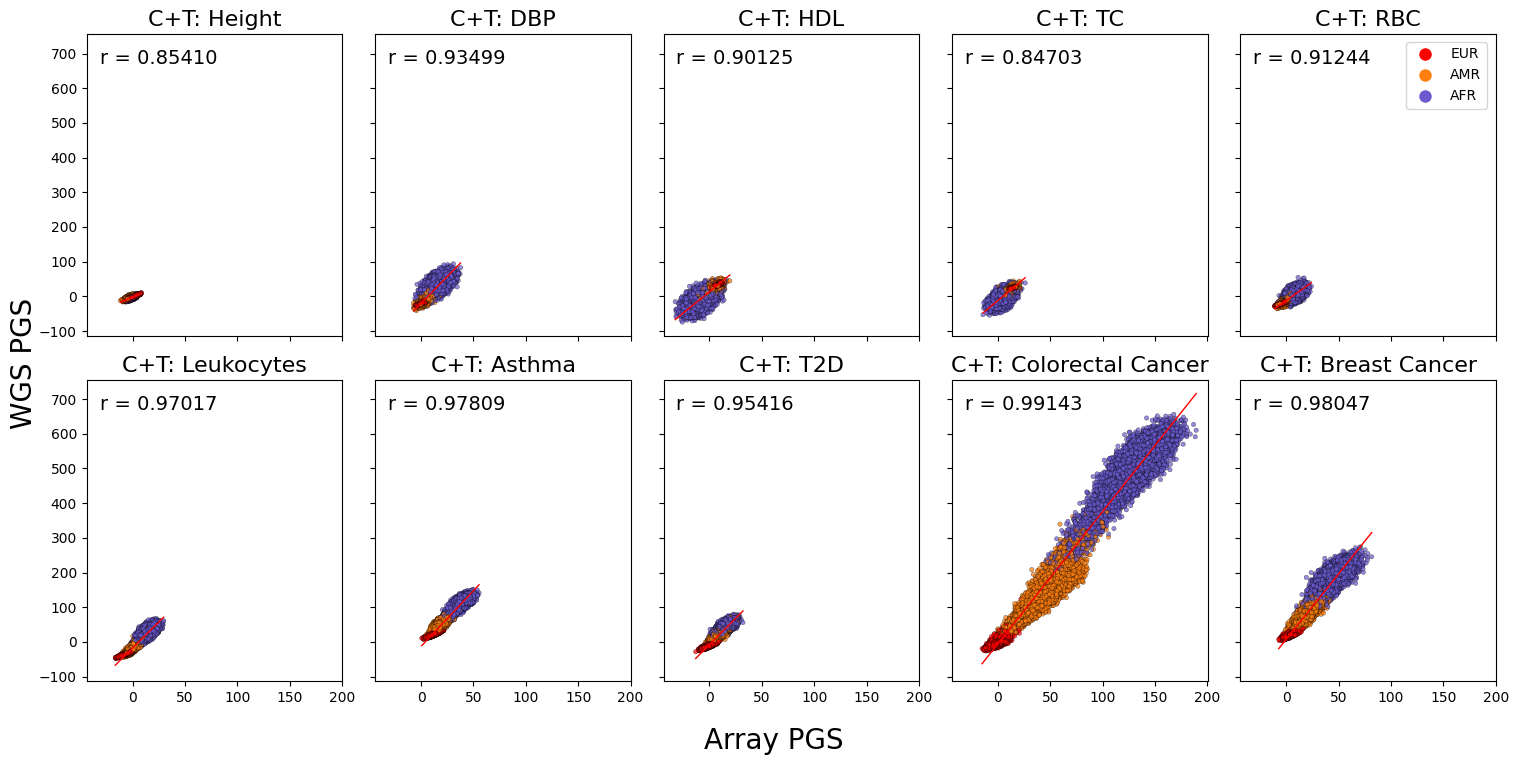

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Original list of phenotypes and DataFrames (assuming dfs is defined as before)
phenotypes = ['Height', 'DBP', 'HDL', 'TC', 'RBC', 'leukocyte', 'Asthma', 'T2D', 'Colorectal_Cancer', 'Breast_Cancer']
dfs = {
    'Height': df_Height,
    'DBP': df_DBP,
    'HDL': df_HDL,
    'TC': df_TC,
    'RBC': df_RBC,
    'leukocyte': df_leukocyte,
    'Asthma': df_Asthma,
    'T2D': df_T2D,
    'Colorectal_Cancer': df_Colorectal_Cancer,
    'Breast_Cancer': df_Breast_Cancer
}

# Rename the phenotypes (3 chosen phenotypes)
phenotypes_renamed = ['Height', 'DBP', 'HDL', 'TC', 'RBC', 'Leukocytes', 'Asthma', 'T2D', 'Colorectal Cancer', 'Breast Cancer']

# Color map for the populations
color_map = {
    'EUR': 'red',
    'AMR': '#ff7f0e',  
    'AFR': 'slateblue'
}

# Create a 2x5 grid of subplots (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(15, 8), sharex=True, sharey=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through the list of phenotypes and plot on each subplot
for i, pheno in enumerate(phenotypes_renamed):
    original_pheno = phenotypes[i]  # Get the original phenotype name to access the dataframe
    if original_pheno in dfs:
        df = dfs[original_pheno]
        
        # Calculate the correlation between the two columns
        correlation = np.corrcoef(df['pgs_mean_x'], df['pgs_mean_y'])[0, 1]

        # Scatter plot of PGS with colors based on Population
        sns.scatterplot(x='pgs_mean_x', y='pgs_mean_y', hue='Population', palette=color_map, data=df, ax=axes[i], 
                        s=10, alpha=0.7, edgecolor='black', legend=False)

        # Regression line (no scatter, just the line)
        sns.regplot(x='pgs_mean_x', y='pgs_mean_y', data=df, ax=axes[i], scatter=False, color='red', line_kws={'linewidth': 1}, ci=None)

        # Labeling the plot
        axes[i].set_xlabel('', fontsize=10)
        axes[i].set_ylabel('', fontsize=10)
        
        # Correct string formatting for the plot title with larger font size
        axes[i].set_title(f'C+T: {pheno}', fontsize=16)

        # Adding the correlation value to the plot with increased font size
        axes[i].text(0.05, 0.95, f'r = {correlation:.5f}', ha='left', va='top', 
                     transform=axes[i].transAxes, color='black', fontsize=14)
    else:
        print(f"DataFrame for {original_pheno} not found.")

    
# Set shared axis titles
fig.supxlabel("Array PGS", fontsize=20)  # Shared x-axis title
fig.text(0, 0.5, "WGS PGS", ha='center', va='center', fontsize=20, rotation=90)  # Shared y-axis title

# Create a custom legend manually (set order and remove title)
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[pop], markersize=10) 
           for pop in ['EUR', 'AMR', 'AFR']]

# Add the legend to the upper-right corner inside the plot frame (adjust `bbox_to_anchor`)
fig.legend(handles, ['EUR', 'AMR', 'AFR'], loc='upper right', bbox_to_anchor=(0.98, 0.91), title=None)

# Adjust layout to prevent overlapping subplots and ensure the shared titles fit
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the shared titles

# Show the plot
plt.show()

## Array vairants passing thresholds

In [4]:
import pandas as pd
import numpy as np

In [31]:
Height_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_Height_QCed_clumped.tsv', sep='\t')
DBP_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_DBP_QCed_clumped.tsv', sep='\t')
HDL_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_HDL_QCed_clumped.tsv', sep='\t')
TC_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_TC_QCed_clumped.tsv', sep='\t')
RBC_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_RBC_QCed_clumped.tsv', sep='\t')
leukocyte_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_leukocyte_QCed_clumped.tsv', sep='\t')
Asthma_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_Asthma_QCed_clumped.tsv', sep='\t')
T2D_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_T2D_QCed_clumped.tsv', sep='\t')
Colorectal_Cancer_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_Colorectal_Cancer_QCed_clumped.tsv', sep='\t')
Breast_Cancer_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/Array_Breast_Cancer_QCed_clumped.tsv', sep='\t')

In [32]:
import pandas as pd

# List of phenotypes
phenotypes = ['Height', 'DBP', 'HDL', 'TC', 'RBC', 'leukocyte', 'Asthma', 'T2D', 'Colorectal_Cancer', 'Breast_Cancer']


# Thresholds to check against
thresholds = ["t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8", "t9", "t10"]
values = [1, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

# Create an empty dictionary to store the DataFrames
phenotype_dataframes = {}

# Loop through phenotypes and create a DataFrame for each
for pheno in phenotypes:
    sumstats = globals().get(f'{pheno}_sumstats')  
    
    # If the phenotype requires pval_meta_hq, use that column
    if pheno in ['DBP', 'HDL', 'Height', 'RBC', 'TC', 'leukocyte']:
        pval_column = 'pval_meta_hq'
    else:
        pval_column = 'pval_meta'
    
    # Compute Nvariants for each threshold
    Nvariants = [len(sumstats[sumstats[pval_column] < value]) for value in values]
    
    # Create the DataFrame for this phenotype
    phenotype_df = pd.DataFrame({
        'threshold': thresholds,
        'Nvariants': Nvariants
    })
    
    # Store the DataFrame in the dictionary
    phenotype_dataframes[pheno] = phenotype_df

In [35]:
# Create a list to hold all phenotype DataFrames
combined_data = []

# Loop through the phenotypes and concatenate them into a single DataFrame
for pheno in phenotype_dataframes:
    phenotype_df = phenotype_dataframes[pheno]
    # Add a new 'phenotype' column with the corresponding phenotype repeated 10 times
    phenotype_df['phenotype'] = [pheno] * 10  # Repeating the phenotype name 10 times
    combined_data.append(phenotype_df)

# Concatenate all the DataFrames row-wise (axis=0)
combined_df = pd.concat(combined_data, axis=0, ignore_index=True)

## WGS variants passing thresholds

In [37]:
Height_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_Height_QCed_clumped.tsv', sep='\t')
DBP_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_DBP_QCed_clumped.tsv', sep='\t')
HDL_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_HDL_QCed_clumped.tsv', sep='\t')
TC_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_TC_QCed_clumped.tsv', sep='\t')
RBC_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_RBC_QCed_clumped.tsv', sep='\t')
leukocyte_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_leukocyte_QCed_clumped.tsv', sep='\t')
Asthma_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_Asthma_QCed_clumped.tsv', sep='\t')
T2D_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_T2D_QCed_clumped.tsv', sep='\t')
Colorectal_Cancer_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_Colorectal_Cancer_QCed_clumped.tsv', sep='\t')
Breast_Cancer_sumstats = pd.read_csv(f'{bucket}/Sumstats_clumped/WGS_Breast_Cancer_QCed_clumped.tsv', sep='\t')

In [38]:
# List of phenotypes
phenotypes = ['Height', 'DBP', 'HDL', 'TC', 'RBC', 'leukocyte', 'Asthma', 'T2D', 'Colorectal_Cancer', 'Breast_Cancer']

# Thresholds to check against
thresholds = ["t1", "t2", "t3", "t4", "t5", "t6", "t7", "t8", "t9", "t10"]
values = [1, 0.5, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]

# Create an empty dictionary to store the DataFrames
phenotype_dataframes = {}

# Loop through phenotypes and create a DataFrame for each
for pheno in phenotypes:
    sumstats = globals().get(f'{pheno}_sumstats')  
    
    # Compute Nvariants for each threshold
    Nvariants = [len(sumstats[sumstats['pval_meta'] < value]) for value in values]
    
    # Create the DataFrame for this phenotype
    phenotype_df = pd.DataFrame({
        'threshold': thresholds,
        'Nvariants': Nvariants
    })
    
    # Store the DataFrame in the dictionary
    phenotype_dataframes[pheno] = phenotype_df

In [41]:
# Create a list to hold all phenotype DataFrames
combined_data = []

# Loop through the phenotypes and concatenate them into a single DataFrame
for pheno in phenotype_dataframes:
    phenotype_df = phenotype_dataframes[pheno]
    # Add a new 'phenotype' column with the corresponding phenotype repeated 10 times
    phenotype_df['phenotype'] = [pheno] * 10  # Repeating the phenotype name 10 times
    combined_data.append(phenotype_df)

# Concatenate all the DataFrames row-wise (axis=0)
combined_df = pd.concat(combined_data, axis=0, ignore_index=True)